In [1]:
%cd ..
%load_ext autoreload
%autoreload 2


/home/teo/userdata/git_libraries/Yeominrak


In [2]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch

import numpy as np
from tqdm.auto import tqdm

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, TestScore, SimpleNote
from model_zoo import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from decode import MidiDecoder
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from fractions import Fraction
import copy


In [4]:
org_set = AlignedScore()

In [3]:
dataset = AlignedScore('yeominlak_omr.musicxml')

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [5]:
class TestScore(AlignedScore):
    def __init__(self, xml_path='0_edited.musicxml', 
                 valid_measure_num=[i for i in range(93, 104)], 
                 slice_measure_num=2, 
                 is_valid=False, 
                 use_pitch_modification=False, 
                 pitch_modification_ratio=0, 
                 min_meas=3, 
                 max_meas=6, 
                 transpose=0, 
                 feature_types=['index', 'pitch', 'duration', 'offset', 'dynamic', 'measure_idx'],
                 sampling_rate=None) -> None:
        # DYNAMIC_MAPPING[0] = {0.0: 'strong', 1.5: 'strong', 3.0: 'middle'}
        super().__init__(xml_path, valid_measure_num, slice_measure_num, is_valid, use_pitch_modification, pitch_modification_ratio, min_meas, max_meas, feature_types)
        self.transpose_value = transpose
        self.transpose()
        self.result_pairs = self.result_pairs[:len(self.slice_info)]

    # def fix_part_zero_duration(self):
    #     return
    def fix_part_by_rule(self):
        flattened_notes = [SimpleNote(note) for measure in self.parts[0].measures for note in measure]
                  
        measure_shifted_notes = []
        for note in flattened_notes:
          new_offset = (note.measure_offset - 1.5 )
          new_note = None
          if note.pitch == 44:
            note.pitch = 45 # 44 is error
          if note.duration > 4:
            break
          if new_offset < 0:
            new_offset += 4
            note.measure_number -= 1
            note.end_measure_number -= 1
            if note.measure_number <= 0:
              new_note = copy.copy(note)
              new_note.measure_offset = 0
              new_note.duration = 4 - note.duration
              measure_shifted_notes.append(new_note)
              new_note = None
          note.measure_offset = new_offset
          if note.measure_offset + note.duration > 4:
            # print("note duration is too long", note.measure_offset, note.duration)
            extended_duration = note.measure_offset + note.duration - 4
            note.duration -= extended_duration
            new_note = copy.copy(note)
            new_note.measure_offset = 0
            new_note.measure_number += 1
            new_note.end_measure_number += 1
            new_note.duration = extended_duration
          measure_shifted_notes.append(note)
          if new_note:
            measure_shifted_notes.append(new_note)
        new_note = copy.copy(note)
        new_note.measure_offset += note.duration
        new_note.duration = 1.5
        measure_shifted_notes.append(new_note)

        measure_shifted_notes.sort(key=lambda x: (x.measure_number, x.measure_offset))

        # make measure list
        note_by_measure = []
        temp_measure = []
        prev_measure_number = 0
        for note in measure_shifted_notes:
          if note.measure_number != prev_measure_number:
            note_by_measure.append(temp_measure)
            temp_measure = []
            prev_measure_number = note.measure_number
          temp_measure.append(note)
        note_by_measure.append(temp_measure)

        self.parts[0].measures = note_by_measure
        self.measure_features = [self.get_feature(i) for i in range(len(self.parts))]

        part_zero = self.measure_features[0].copy()
        for measure in part_zero:
          for note in measure:
            note[2] *= 2
            note[3] *= 2
        self.measure_features[0] = part_zero
        self.offset_list[0] *= 2


    def transpose(self):
      for idx in range(len(self.parts)):
        part_zero = self.measure_features[idx].copy()
        for measure in part_zero:
          for note in measure:
            note[1] += self.transpose_value
        self.measure_features[idx] = part_zero

    def get_processed_feature(self, front_part_idx, back_part_idx, idx):
      source_start_token = [front_part_idx, 'start', 'start', 'start', 'start', 'start']
      source_end_token = [front_part_idx, 'end', 'end', 'end', 'end', 'end']
      if self.is_valid:
          measure_list = idx
      else:    
          measure_list = self.slice_info[idx]
      original_source_list = [item for idx in measure_list for item in self.measure_features[front_part_idx][idx]]
      if 'measure_idx' in self.tokenizer.key_types:
        m_idx_pos = self.tokenizer.key2idx['measure_idx']
        source_first_measure_idx = original_source_list[0][m_idx_pos]

        original_source_list = [note[:m_idx_pos] + [note[m_idx_pos]-source_first_measure_idx] + note[m_idx_pos+1:] for note in original_source_list]

      source_list = [source_start_token] + original_source_list + [source_end_token]
      source = [self.tokenizer(note_feature) for note_feature in source_list]
      
      return torch.LongTensor(source)
        
    def __getitem__(self, idx):

      front_part_idx, back_part_idx, measure_idx = self.result_pairs[idx]
      src = self.get_processed_feature(front_part_idx, back_part_idx, measure_idx)
      
      return src


In [6]:

def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[-1] == 4: # new measure started:
      break
  for j in range(i, len(output)):
    if output[j][-1] == 6:
      break

  output_tokens_from_second_measure = output[i:j].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  output_tokens_from_second_measure[:, 5] -= 1
  return output_tokens_from_second_measure


def prepare_input_for_next_part(outputs_tensor):
  pred, condition = outputs_tensor[:, :3], outputs_tensor[:, 3:]
  next_input = torch.cat([torch.cat([pred[0:1], torch.tensor([[3,3,3]])], dim=1) , torch.cat([pred[1:], condition[:-1]], dim=1) ], dim=0)
  return next_input

def get_measure_specific_output(output:torch.LongTensor, measure_idx_in_token:int):
  corresp_ids = torch.where(output[:,-1] == measure_idx_in_token)[0]+1
  return output[corresp_ids]


def fix_measure_idx(sample:torch.LongTensor):
  new_sample = sample.clone()
  current_measure = 2
  for note in new_sample:
    if note[1] in (1, 2): continue
    if note[3] == 3: # beat_start
      current_measure += 1
    note[5] = current_measure
  return new_sample

def recover_beat(output:torch.LongTensor, tokenizer, recover_amount=5):
  new_output = output.clone()
  accum_dur = 0
  for i, token in enumerate(new_output):
    accum_dur += tokenizer.vocab['duration'][token[2]]
    if abs(accum_dur - recover_amount) < 0.1:
      break
    elif accum_dur > recover_amount+0.1:
      print('Exceed!', accum_dur, recover_amount)
      exceed_amount = accum_dur - recover_amount
      new_output[i+1, 2] = tokenizer.tok2idx['duration'][round(tokenizer.vocab['duration'][new_output[i+1, 2]] + exceed_amount)]
      break


  return new_output[i+1:]


def fill_in_source(src, num_measure):
  # src: list of token in strings
  outputs = []
  for note in src:
    if note[-1] in range(4-num_measure):
      continue
    else:
      outputs.append(note)
  return outputs


In [7]:
save_name = 'dropout0.5_bestacc'
state = torch.load('outputs/2023-12-12/04-08-05/best_model.pt')

# save_name = 'vanilla_seq2seq_bestacc'
# state = torch.load('outputs/2023-12-12/04-46-10/best_model.pt')


config = OmegaConf.load('yamls/baseline.yaml')
config = get_emb_total_size(config)
device = 'cpu'
val_dataset = ShiftedAlignedScore(is_valid= True, slice_measure_num=4, feature_types=config.model.features)
valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)
model = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
# state = torch.load('best_model.pt')
model.load_state_dict(state)
model.eval()
decoder = MidiDecoder(val_dataset.tokenizer)


In [91]:
class TestScoreCPH(TestScore):
  def __init__(self, xml_path='0_edited.musicxml', valid_measure_num=..., slice_measure_num=2, is_valid=False, use_pitch_modification=False, pitch_modification_ratio=0, min_meas=3, max_meas=6, transpose=0, feature_types=..., sampling_rate=None) -> None:
    super().__init__(xml_path, valid_measure_num, slice_measure_num, is_valid, use_pitch_modification, pitch_modification_ratio, min_meas, max_meas, transpose, feature_types, sampling_rate)


  def fix_part_by_rule(self):
    flattened_notes = [SimpleNote(note) for measure in self.parts[0].measures for note in measure]
              
    measure_shifted_notes = []
    for note in flattened_notes:
      new_offset = (note.measure_offset - 2.5 )
      new_note = None

      ### pitch modification
      if note.pitch == 51:
        note.pitch = 52 # 51 is error
      if note.pitch == 39:
        note.pitch = 40
      if note.pitch == 56:
        note.pitch = 57
      if note.pitch == 57:
        note.pitch = 45

      if new_offset < 0:
        new_offset += 4
        note.measure_number -= 1
        note.end_measure_number -= 1
      note.measure_offset = new_offset
      if note.measure_offset + note.duration > 4:
        # print("note duration is too long", note.measure_offset, note.duration)
        extended_duration = note.measure_offset + note.duration - 4
        note.duration -= extended_duration
        new_note = copy.copy(note)
        new_note.measure_offset = 0
        new_note.measure_number += 1
        new_note.end_measure_number += 1
        new_note.duration = extended_duration
      measure_shifted_notes.append(note)
      if new_note:
        measure_shifted_notes.append(new_note)
    new_note = copy.copy(note)
    new_note.measure_offset += note.duration
    new_note.duration = 2.5
    measure_shifted_notes.append(new_note)

    beginning_dummy_note = copy.copy(measure_shifted_notes[0])
    beginning_dummy_note.measure_offset = 0
    beginning_dummy_note.duration = 1.5
    measure_shifted_notes.append(beginning_dummy_note)

    measure_shifted_notes.sort(key=lambda x: (x.measure_number, x.measure_offset))

    # make measure list
    note_by_measure = []
    temp_measure = []
    prev_measure_number = 0
    for note in measure_shifted_notes:
      if note.measure_number != prev_measure_number:
        note_by_measure.append(temp_measure)
        temp_measure = []
        prev_measure_number = note.measure_number
      temp_measure.append(note)
    note_by_measure.append(temp_measure)

    self.parts[0].measures = note_by_measure
    self.measure_features = [self.get_feature(i) for i in range(len(self.parts))]

    part_zero = self.measure_features[0].copy()
    for measure in part_zero:
      for note in measure:
        note[2] *= 2
        note[3] *= 2
    self.measure_features[0] = part_zero
    self.offset_list[0] *= 2

  


test_set = TestScoreCPH(xml_path='chwipunghyeong.musicxml', is_valid=True, 
                     valid_measure_num=[i for i in range(69)], slice_measure_num=4, transpose=+8, feature_types=config.model.features)
test_set.tokenizer = val_dataset.tokenizer

for idx in range(len(test_set)):
  test_set[idx]

In [84]:
config = OmegaConf.load('yamls/baseline.yaml')
config = get_emb_total_size(config)
device = 'cpu'
val_dataset = ShiftedAlignedScore(is_valid= True, slice_measure_num=4, feature_types=config.model.features)
valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)
model = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
# state = torch.load('best_model.pt')
model.load_state_dict(state)
model.eval()
decoder = MidiDecoder(val_dataset.tokenizer)


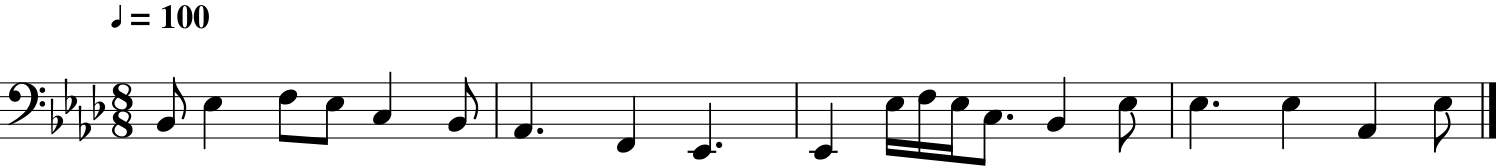

In [95]:
decoder(model.converter(test_set[4][1:-1])).show()

In [76]:
Counter([note.pitch for measure in test_set.parts[0].measures for note in measure])

Counter({43.0: 139,
         45.0: 76,
         40.0: 21,
         38.0: 36,
         36.0: 21,
         33.0: 1,
         31.0: 3,
         50.0: 120,
         52.0: 122,
         55.0: 77,
         48.0: 81})

In [77]:
from collections import Counter
print(Counter([note[1] for measure in test_set.measure_features[0] for note in measure]))
sorted(list(set([note[1] for measure in test_set.measure_features[0] for note in measure])))

Counter({51.0: 137, 60.0: 122, 58.0: 120, 56.0: 81, 63.0: 77, 53.0: 74, 46.0: 36, 48.0: 21, 44.0: 21, 39.0: 3, 41.0: 1})


[39.0, 41.0, 44.0, 46.0, 48.0, 51.0, 53.0, 56.0, 58.0, 60.0, 63.0]

In [21]:
val_datset = ShiftedAlignedScore(is_valid=True, slice_measure_num=4, feature_types=config.model.features)

In [73]:
print(val_dataset.tokenizer.vocab['pitch'])

['pad', 'start', 'end', 34.0, 39.0, 41.0, 44.0, 46.0, 48.0, 49.0, 51.0, 53.0, 55.0, 56.0, 58.0, 60.0, 63.0]


In [13]:
part_measure_with_errors = []

for part_idx, part in enumerate(train_dataset.parts):
  for measuer_idx, measure in enumerate(part.measures):
    if measure == []:
      continue
    duration = sum([note.duration for note in measure])
    if part_idx in [0] and abs(duration-4) > 0.1 \
    or part_idx in [1] and abs(duration-8) > 0.1 \
    or part_idx in [2,3,4,5,6,7] and abs(duration-10) > 0.1:
      print(part_idx, measuer_idx, duration)
      part_measure_with_errors.append((part_idx+1, measuer_idx+1))

print(part_measure_with_errors)


2 42 9.0
2 49 9.0
2 56 9.0
2 108 9.0
3 42 9.0
3 49 9.0
3 56 9.0
3 84 9.0
3 108 9.0
4 3 11.0
4 18 11.0
4 42 4.0
4 49 9.0
4 54 6.0
4 64 2.0
5 13 6.0
5 25 6.0
5 49 9.0
5 51 7.0
5 89 6.0
5 114 9.0
6 1 11.0
[(3, 43), (3, 50), (3, 57), (3, 109), (4, 43), (4, 50), (4, 57), (4, 85), (4, 109), (5, 4), (5, 19), (5, 43), (5, 50), (5, 55), (5, 65), (6, 14), (6, 26), (6, 50), (6, 52), (6, 90), (6, 115), (7, 2)]


In [ ]:
[(3, 43), (3, 50), (3, 57), (3, 109), (4, 43), (4, 50), (4, 57), (4, 85), (4, 109), (5, 4), (5, 19), (5, 43), (5, 50), (5, 55), (5, 65), (6, 14), (6, 26), (6, 50), (6, 52), (6, 90), (6, 115), (7, 2)]

In [12]:
train_dataset.parts[0].measures

[[Gnote: 30.0, 4.0, 0.0, strong],
 [Gnote: 27.0, 4.0, 0.0, strong],
 [Gnote: 27.0, 4.0, 0.0, strong],
 [Gnote: 25.0, 2.5, 0.0, strong, Gnote: 27.0, 1.5, 2.5, strong],
 [Gnote: 32.0, 4.0, 0.0, strong],
 [Gnote: 32.0, 4.0, 0.0, strong],
 [Gnote: 32.0, 4.0, 0.0, strong],
 [Gnote: 32.0, 4.0, 0.0, strong],
 [Gnote: 30.0, 4.0, 0.0, strong],
 [Gnote: 30.0, 4.0, 0.0, strong],
 [Gnote: 32.0, 4.0, 0.0, strong],
 [Gnote: 32.0, 2.5, 0.0, strong, Gnote: 30.0, 1.5, 2.5, strong],
 [Gnote: 27.0, 4.0, 0.0, strong],
 [Gnote: 25.0, 2.5, 0.0, strong, Gnote: 23.0, 1.5, 2.5, strong],
 [Gnote: 25.0, 4.0, 0.0, strong],
 [Gnote: 27.0, 2.5, 0.0, strong, Gnote: 25.0, 1.5, 2.5, strong],
 [Gnote: 23.0, 4.0, 0.0, strong],
 [Gnote: 23.0, 2.5, 0.0, strong,
  Gnote: 25.0, 1.0, 2.5, strong,
  Gnote: 23.0, 0.5, 3.5, weak],
 [Gnote: 20.0, 4.0, 0.0, strong],
 [Gnote: 18.0, 2.5, 0.0, strong, Gnote: 20.0, 1.5, 2.5, strong],
 [Gnote: 23.0, 2.5, 0.0, strong, Gnote: 25.0, 1.5, 2.5, strong],
 [Gnote: 27.0, 4.0, 0.0, strong],
 [

In [8]:
with open('0_fixed.musicxml', 'r') as file:
  xml_lines = file.readlines()

new_xml_lines = []
measure_boundary_skipped = False

for line in xml_lines:
  if "<measure number=" in line:
    meas_num = int(line.split('"')[1])
    if meas_num % 2 == 0:
      continue
    else:
      measure_boundary_skipped = True
    new_meas_num = int(meas_num//2+1)
    print(meas_num, new_meas_num)
    new_line = line.replace(f'number="{meas_num}', f'number="{new_meas_num}')
    new_xml_lines.append(new_line)
    continue
  if "</measure>" in line and measure_boundary_skipped:
    measure_boundary_skipped = False
    continue
  new_xml_lines.append(line)

with open('0_fixed_measure_edited.musicxml', 'w') as file:
  file.writelines(new_xml_lines)

1 1
3 2
5 3
7 4
9 5
11 6
13 7
15 8
17 9
19 10
21 11
23 12
25 13
27 14
29 15
31 16
33 17
35 18
37 19
39 20
41 21
43 22
45 23
47 24
49 25
51 26
53 27
55 28
57 29
59 30
61 31
63 32
65 33
67 34
69 35
71 36
73 37
75 38
77 39
79 40
81 41
83 42
85 43
87 44
89 45
91 46
93 47
95 48
97 49
99 50
101 51
103 52
105 53
107 54
109 55
111 56
113 57
115 58
117 59
119 60
121 61
123 62
125 63
127 64
129 65
131 66
133 67
135 68
137 69
139 70
141 71
143 72
145 73
147 74
149 75
151 76
153 77
155 78
157 79
159 80
161 81
163 82
165 83
167 84
169 85
171 86
173 87
175 88
177 89
179 90
181 91
183 92
185 93
187 94
189 95
191 96
193 97
195 98
197 99
199 100
201 101
203 102
205 103
207 104
209 105
211 106
213 107
215 108
217 109
219 110
221 111
223 112
225 113
227 114
229 115
231 116
233 117
235 118
237 119
239 120
241 121
243 122
245 123
247 124
249 125
251 126
253 127
255 128
257 129
259 130
261 131
263 132
265 133
267 134
269 135
271 136
273 137
275 138
277 139
279 140
281 141
283 142
285 143
287 144
289 145
291